Solutions for ML2 Spiking Network Exercise with PyNN & NEST
==============

Let's import all we need and define the utility functions

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import pyNN.nest as sim
import numpy as np
from imageio import imread
from matplotlib import animation 
import matplotlib.pyplot as plt
from IPython.display import HTML
sim.setup()

CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


/home/jkaiser/.local/lib/python3.6/site-packages/pyNN/nest/__init__.py:53: UserWarning:Unable to install NEST extensions. Certain models may not be available.
/usr/lib/python3.6/dist-packages/nest/lib/hl_api_helper.py:127: UserWarning:
ResetNetwork is deprecated and will be removed in NEST 3.0.


0

In [3]:
import IPython.display
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

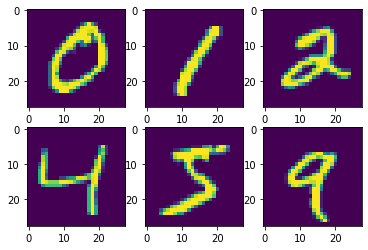

In [4]:
%matplotlib inline
fig, axes = plt.subplots(2,3)

stimuli_filenames = [
    "m0.png",
    "m1.png",
    "m2.png",
    "m4.png",
    "m5.png",
    "m9.png"
]

stimuli = [ imread('images/'+stimulus) for stimulus in stimuli_filenames]
for ii, stimulus in enumerate(stimuli):
    ax = plt.subplot(2,3,ii+1)
    ax.imshow(stimulus)
input_shape = stimuli[0].shape

In [5]:
stim_exposure = 500
epsilon = 1
max_rate = 100.

def simulate_network(stimuli, input_layer):
    for stim in stimuli:
        # For some reasons, I had issues with setting the rate of input Poisson neurons.
        # So instead, we can use LIF neurons with constant input current
        if isinstance(input_layer.celltype, sim.SpikeSourcePoisson):
            rates = (stim.flatten() / 255. * max_rate + epsilon).tolist()
            input_layer.set(rate=rates)
            sim.run(stim_exposure)
        elif isinstance(input_layer.celltype, sim.IF_curr_exp):
            input_layer.set(i_offset=(stim.flatten() / 255. * 4.).tolist())
            sim.run(stim_exposure)

def create_network(input_shape, n_output):
    np.random.seed(0)
    sim.setup(threads=5, grng_seed=0)
    cell_parameters = {
        "tau_m": 10.0,  # membrane time constant (ms)
        "v_thresh": -50.0,  # spike threshold (mV)
        "v_reset": -60.0,  # reset potential after a spike (mV)
        "v_rest": -60.0,  # resting membrane potential (mV)
        "cm": 1.0,  # membrane capacity (nF)
        "tau_refrac": 2,  # (relative) refractory period (ms)
    }

    input_pop = sim.Population(np.prod(input_shape), 
                               sim.SpikeSourcePoisson(rate=1.),
                               #sim.IF_curr_exp(),
                               label="input",
                               initial_values={
                                    "v": cell_parameters["v_reset"]
                                })
    input_pop.record('spikes') 
    output_pop = sim.Population(n_output,
                                sim.IF_curr_exp(**cell_parameters),
                                label="output",
                                initial_values={
                                    "v": cell_parameters["v_reset"]
                                })
    output_pop.record('spikes') 
    return (input_pop, output_pop)

def reconstruct_image(layer, input_shape, interval):
    spiketrains = layer.get_data().segments[0].spiketrains
    reconstruction = np.zeros(input_shape)
    for i, train in enumerate(spiketrains):
        train = np.array(train)
        activity = len(train[(interval[0] < train) & (train < interval[1])])
        idx_2d = np.unravel_index(i, input_shape)
        reconstruction[idx_2d[0], idx_2d[1]] = activity
    print('Max number of spikes/neuron: {}'.format(int(reconstruction.max())))
    plt.imshow(reconstruction, vmin=0)
    
def plot_spiketrain(layer, n_stimuli):
    # get_data() get the recorded variables (here only spikes) in a Neo object
    spiketrains = layer.get_data().segments[0].spiketrains
    plt.figure(figsize=(14,7))
    ax = plt.subplot(111)
    ax.set_title('{} spiketrain'.format(layer.label))
    ax.set_yticks(range(len(spiketrains)))
    cmap = plt.cm.get_cmap("Dark2", n_stimuli)
    for sp in spiketrains:
        ax.plot(sp,
                np.ones_like(sp) * sp.annotations['source_index'],
                'o', color='b', alpha=0.3)
    # We also plot the vertical lines indicating the start of the stimuli
    xlim = ax.get_xlim()
    ax.set_xlim([0, xlim[1]])
    epoch_duration = stim_exposure * n_stimuli
    n_epoch = xlim[1] / epoch_duration
    for ep in range(int(np.floor(n_epoch))):
        for stim_idx in range(n_stimuli):
            ax.axvline(x= ep * epoch_duration + stim_idx * (stim_exposure),
                      linewidth=3, color=cmap(stim_idx))
            ax.annotate(s='{}'.format(stim_idx), 
                        xy =( ep * epoch_duration + (2 * stim_idx + 1) * (stim_exposure) / 2., 0.5),
                        horizontalalignment='center',
                        color=cmap(stim_idx))
    ax.set_ylabel("Neuron index")
    ax.set_xlabel("Time (ms)")
    
    
def plot_weights(proj, vmin=None, vmax=None, n_cols=4, animated=False):
    all_neurons_weights = np.rollaxis( proj.get('weight', format='array'), 1 )
    max_w = all_neurons_weights.max()
    n_rows = int(np.ceil( ( float(len(all_neurons_weights)) / n_cols) ))
    figsize = (n_cols * 4, n_rows * 4)
    fig, axarr = plt.subplots(n_rows, n_cols,
                              figsize=figsize)
    axarr = axarr.flatten()
    imgs = []
    for i, single_neuron_weights in enumerate(all_neurons_weights):        
        H = np.reshape(single_neuron_weights, input_shape)
        ax = axarr[i]
        
        ax.set_title('Weight matrix For Neuron {}'.format(i))
        imgs.append( 
            ax.imshow(H, vmin=vmin, vmax=vmax, 
                      interpolation="none", aspect="equal",
                      animated = animated)
        )

        cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
        cax.get_xaxis().set_visible(False)
        cax.get_yaxis().set_visible(False)
        cax.patch.set_alpha(0)
        cax.set_frame_on(False)
    return { 'figure': fig, 'imgs': imgs, 'max_weight': max_w }

def create_weight_updates(weight_figs):
    def weight_updates(idx_frame):
        displayed_imgs = weight_figs[0]['imgs']
        curr_fig = weight_figs[idx_frame % len(weight_figs)]
        for idx, im in enumerate(displayed_imgs):
            im.set_array( curr_fig['imgs'][idx].get_array())
        return displayed_imgs
    return weight_updates

## Exercise 1 - Fix the projection
### Solution

All the output neurons have the same spiketrain because the synapses connecting input to output all have the same weights. To fix this, we draw the weights from a normal distribution.

NEST does not allow setting an initial value for V_m
NEST does not allow setting an initial value for isyn_exc
NEST does not allow setting an initial value for isyn_inh


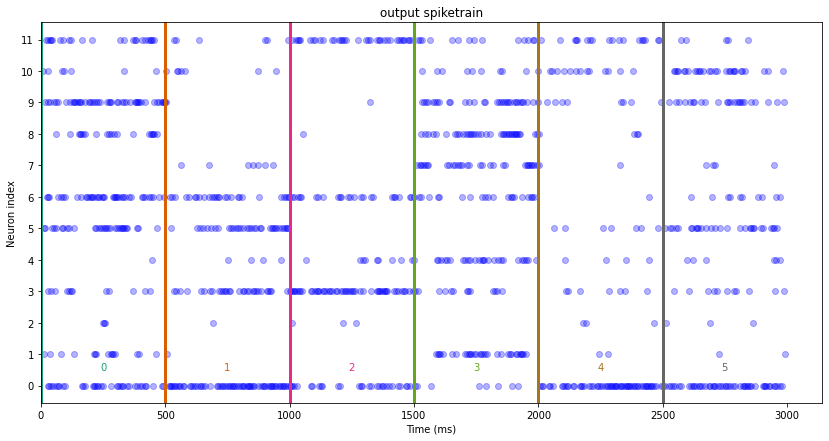

In [6]:
input_layer, output_layer = create_network(input_shape, 12)
initial_weights = sim.random.RandomDistribution('normal', [0., 0.3])
synapses = sim.Projection(input_layer, output_layer,
                          sim.AllToAllConnector(),
                          sim.StaticSynapse(weight=initial_weights))

simulate_network(stimuli, input_layer)
plot_spiketrain(output_layer, len(stimuli))

/home/jkaiser/.local/lib/python3.6/site-packages/ipykernel_launcher.py:106: MatplotlibDeprecationWarning:Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


{'figure': <Figure size 1152x864 with 13 Axes>,
 'imgs': [<matplotlib.image.AxesImage at 0x7ff3fe420860>,
 'max_weight': 1.2099347982502473}

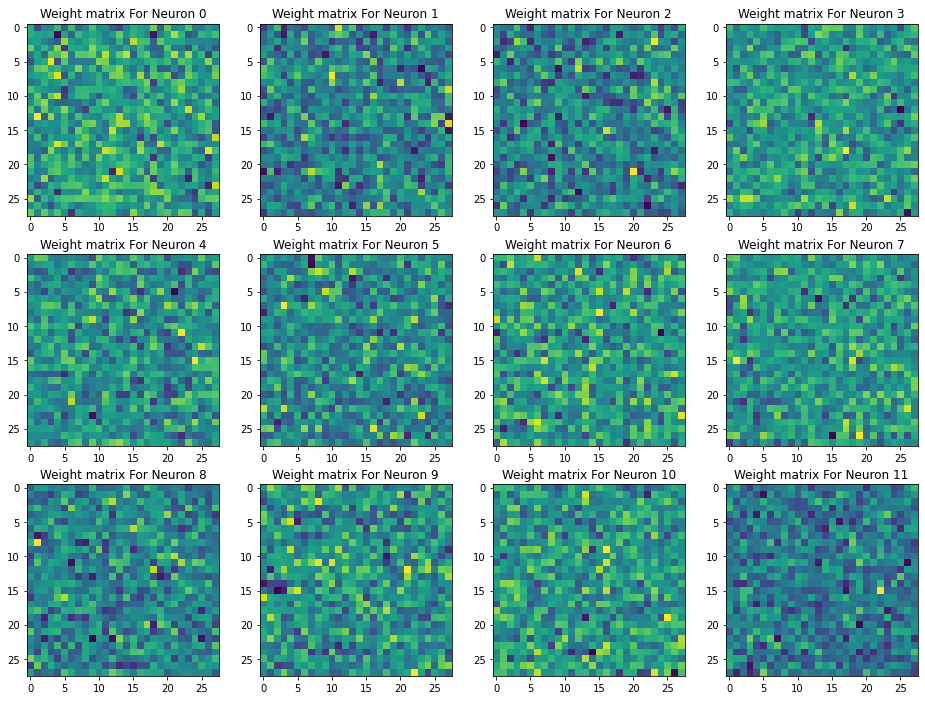

In [7]:
plot_weights(synapses)

## Exercise 2 - Learning features
### Solution

To learn features, we use spike time dependent plasticity (STDP). With PyNN, we need to replace the static weight synapses with STDPMechanism. However, NEST does not support negative weights with STDP, so we instead make multiple synapses between input and output neurons - some static, some plastic.

NEST does not allow setting an initial value for V_m
NEST does not allow setting an initial value for isyn_exc
NEST does not allow setting an initial value for isyn_inh
Several STDP models are available for these connections:
stdp_synapse
By default, stdp_synapse is used
/home/jkaiser/.local/lib/python3.6/site-packages/ipykernel_launcher.py:106: MatplotlibDeprecationWarning:Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


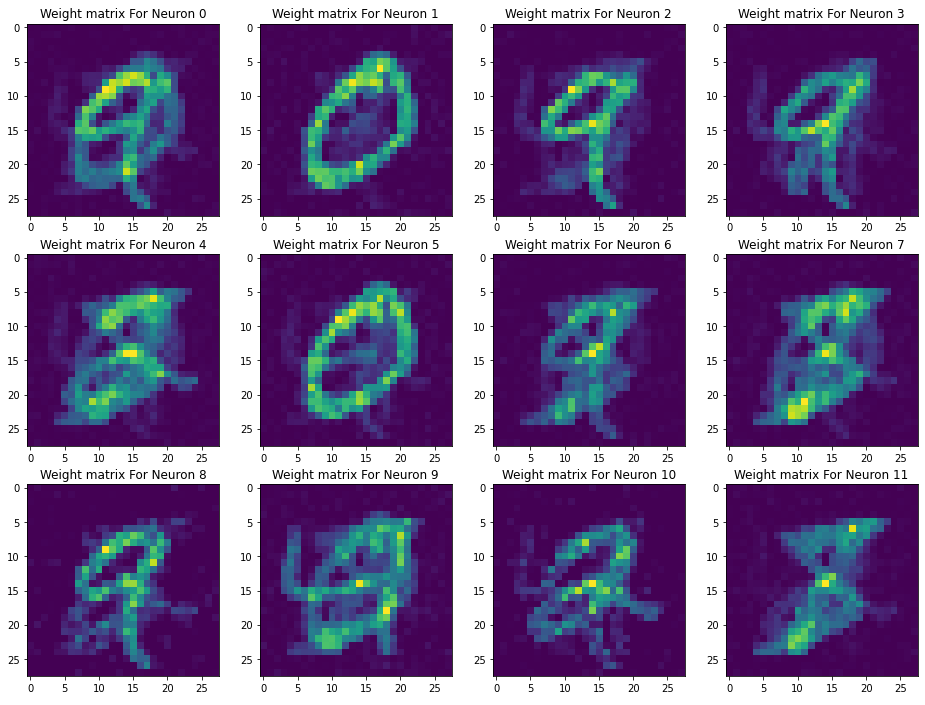

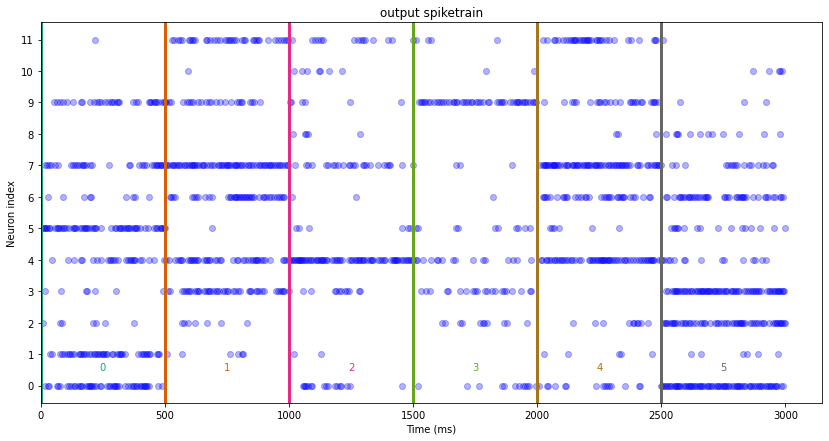

In [8]:
synapse_prob = 1.


input_layer, output_layer = create_network(input_shape, 12)

static_weights = sim.random.RandomDistribution('normal', [0., 0.3])
static_synapses = sim.Projection(input_layer, output_layer,
                                 sim.FixedProbabilityConnector(synapse_prob),
                                 sim.StaticSynapse(weight=static_weights))

# Note: we use a Hebbian rule with negative A_minus, 
# i.e. the weight increases regardless of pre-synaptic neuron or post-synaptic neuron spiked first
plastic_model_exc = sim.STDPMechanism(timing_dependence=sim.SpikePairRule(tau_plus=10.0, tau_minus=10.0,
                                                                          A_plus=1e-5, A_minus=-1e-5),
                                      weight_dependence=sim.MultiplicativeWeightDependence(w_min=0.0, w_max=2.),
                                      weight= 0.000)

plastic_synapses_exc = sim.Projection(input_layer, output_layer,
                                      sim.FixedProbabilityConnector(synapse_prob),
                                      plastic_model_exc)
simulate_network(stimuli, input_layer)
plotted_weights = plot_weights(plastic_synapses_exc)
plot_spiketrain(output_layer, len(stimuli))

max_weight = plotted_weights['max_weight']

## Exercise 3 - Multiple epochs
### Solution

NEST does not allow setting an initial value for V_m
NEST does not allow setting an initial value for isyn_exc
NEST does not allow setting an initial value for isyn_inh
Several STDP models are available for these connections:
stdp_synapse
By default, stdp_synapse is used


Epoch 0


/home/jkaiser/.local/lib/python3.6/site-packages/ipykernel_launcher.py:106: MatplotlibDeprecationWarning:Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Epoch 1
Epoch 2
Epoch 3
Epoch 4


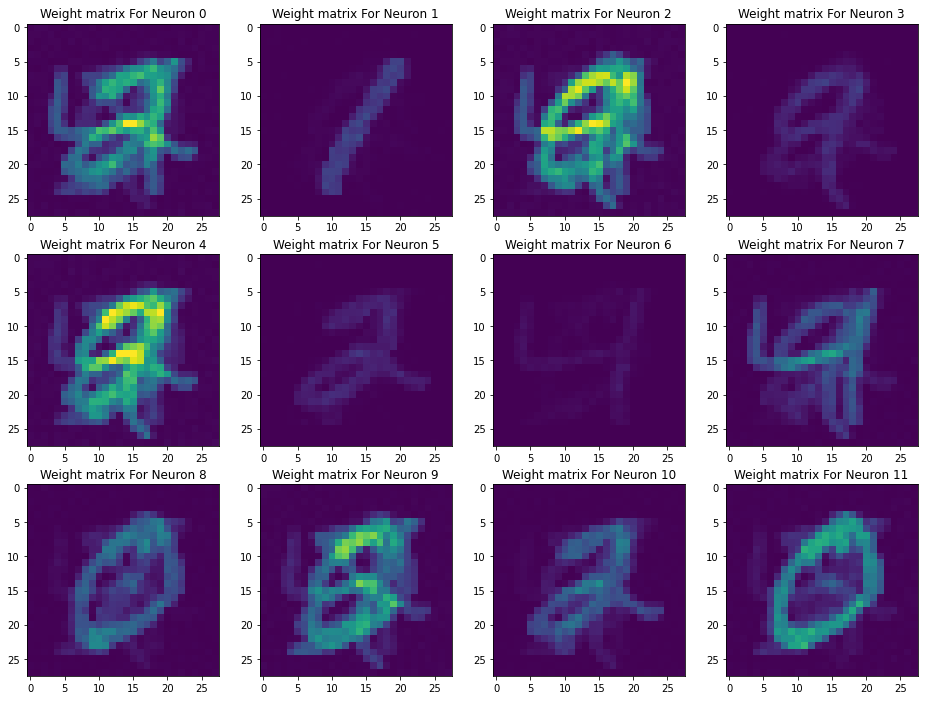

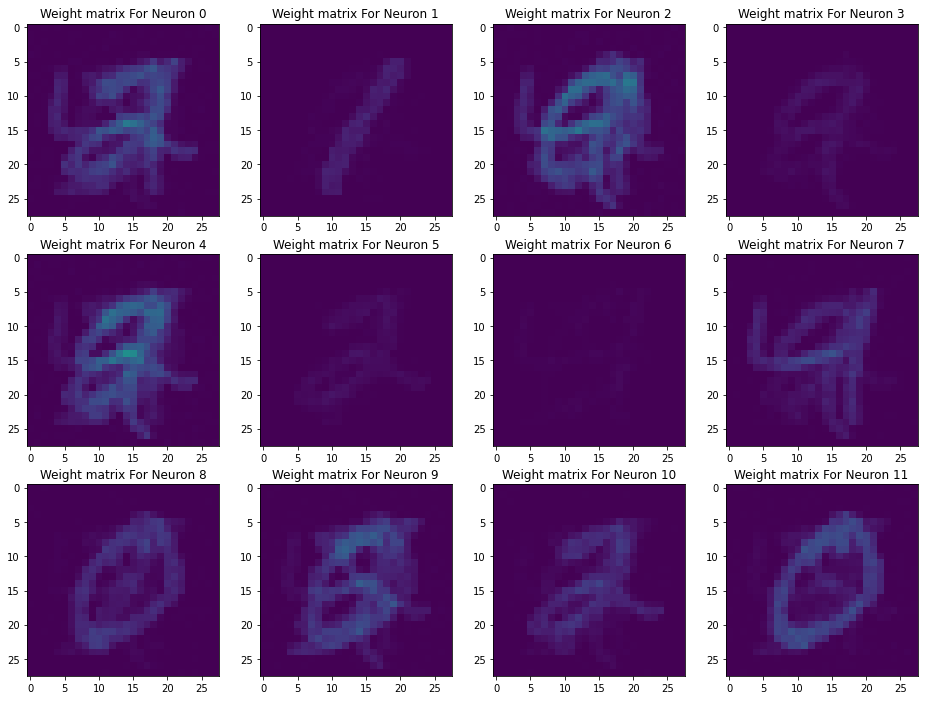

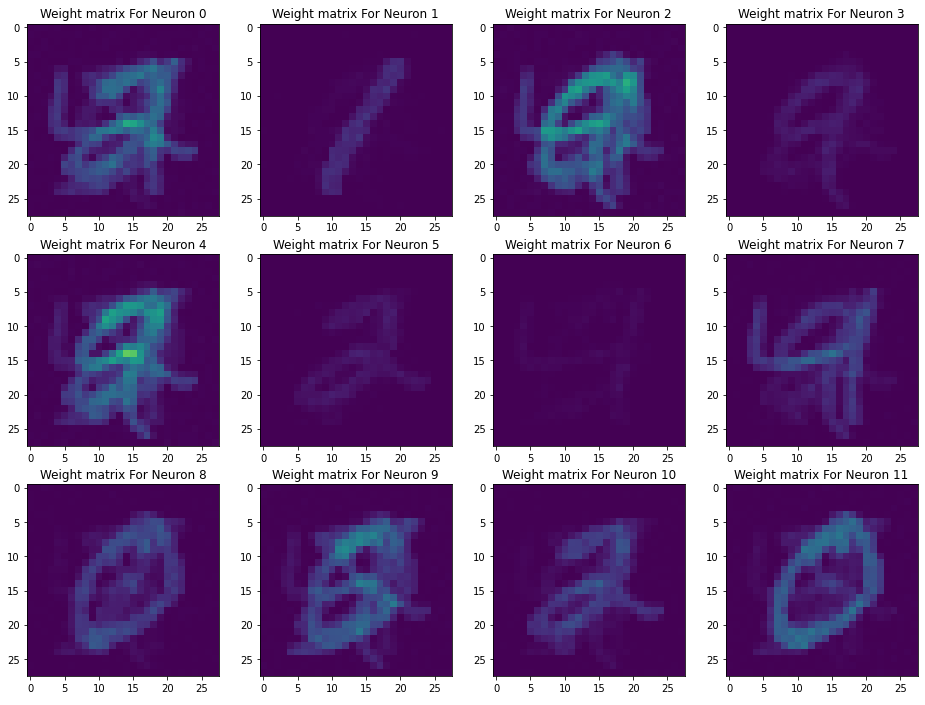

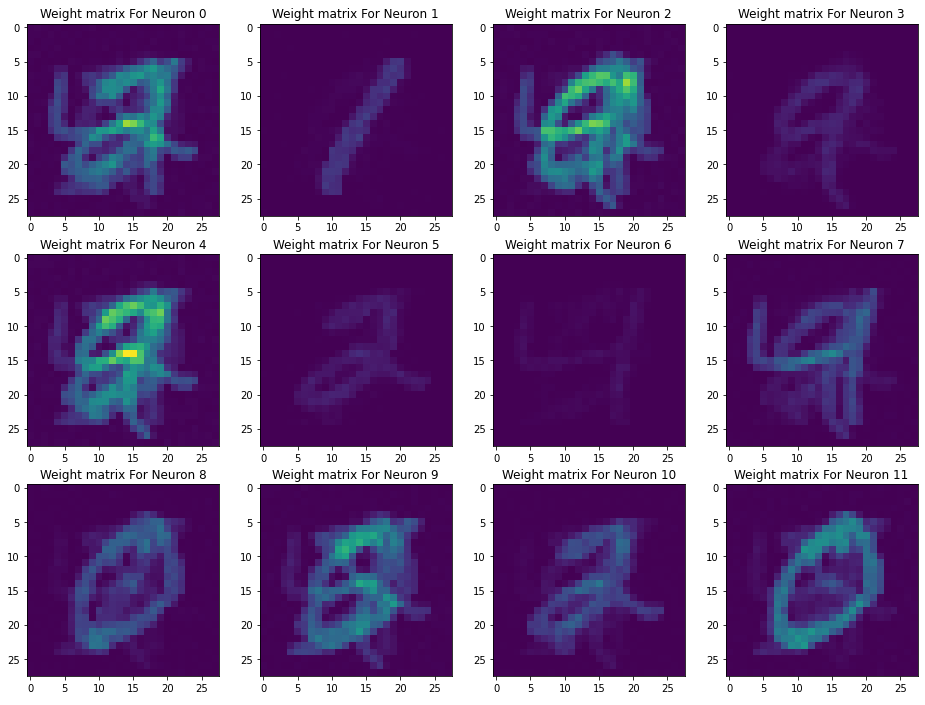

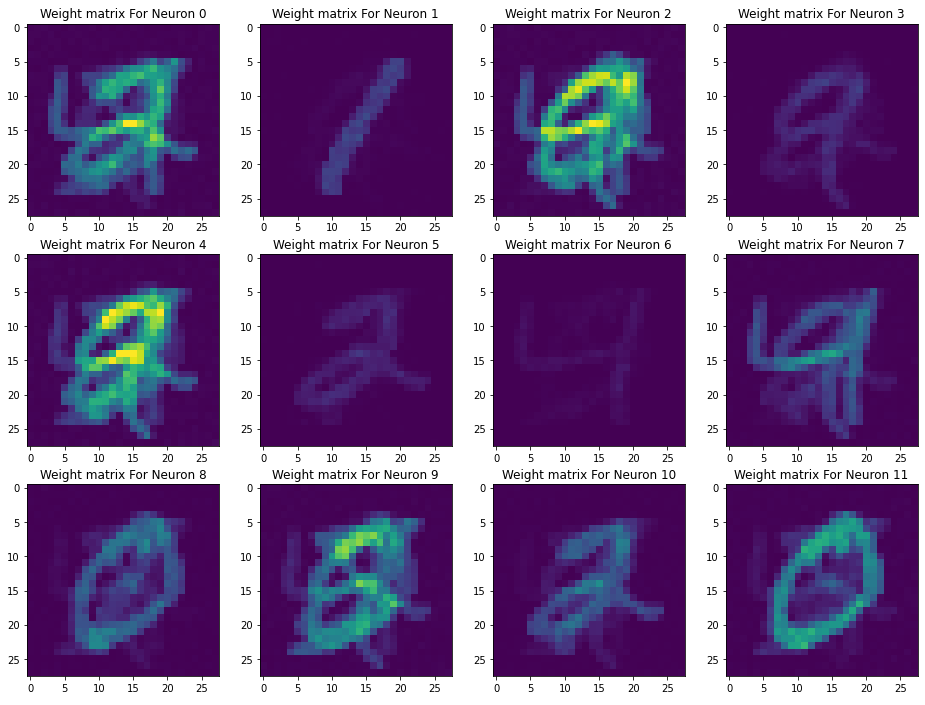

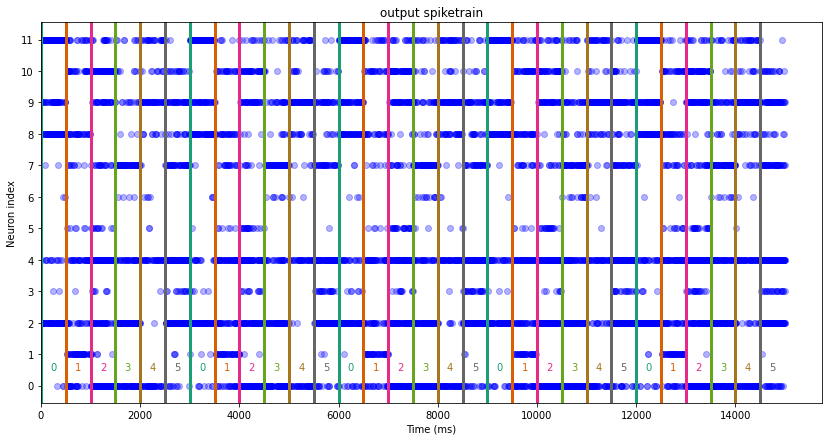

In [9]:
n_epoch = 5
synapse_prob = 1.


input_layer, output_layer = create_network(input_shape, 12)

static_weights = sim.random.RandomDistribution('normal', [0., 0.3])
static_synapses = sim.Projection(input_layer, output_layer,
                                 sim.FixedProbabilityConnector(synapse_prob),
                                 sim.StaticSynapse(weight=static_weights))


plastic_model_exc = sim.STDPMechanism(timing_dependence=sim.SpikePairRule(tau_plus=10.0, tau_minus=10.0,
                                                                          A_plus=1e-5, A_minus=-1e-5),
                                      weight_dependence=sim.MultiplicativeWeightDependence(w_min=0.0, w_max=2.),
                                      weight= 0.000)

plastic_synapses_exc = sim.Projection(input_layer, output_layer,
                                      sim.FixedProbabilityConnector(synapse_prob),
                                      plastic_model_exc)

figs = []
for i in range(n_epoch):
    print('Epoch {}'.format(i))
    simulate_network(stimuli, input_layer)
    figs.append(plot_weights(plastic_synapses_exc, vmax=max_weight*n_epoch, animated=True))

plot_spiketrain(output_layer, len(stimuli))

weight_anim = animation.FuncAnimation(figs[0]['figure'], 
                                      create_weight_updates(figs), 
                                      interval=500,
                                      frames=n_epoch,
                                      blit=True)

HTML(weight_anim.to_html5_video())

## Exercise 4 - Learning discriminative features
### Solution

When an output neuron is initially tuned to a digit (with the initial random weights), the STDP process will increase these weights. However, as most digits have overlapping pixels, this output neuron will also tend to react to other digits. 
Here, we add local inhibition, so that when an output neuron is active, it will prevent the other output neurons to be active (and learn the same digit).

You can also play with the connection probability of the learning synapses, so that the output neurons have different receptive fields from one another.

NEST does not allow setting an initial value for V_m
NEST does not allow setting an initial value for isyn_exc
NEST does not allow setting an initial value for isyn_inh
Several STDP models are available for these connections:
stdp_synapse
By default, stdp_synapse is used
/home/jkaiser/.local/lib/python3.6/site-packages/ipykernel_launcher.py:106: MatplotlibDeprecationWarning:Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


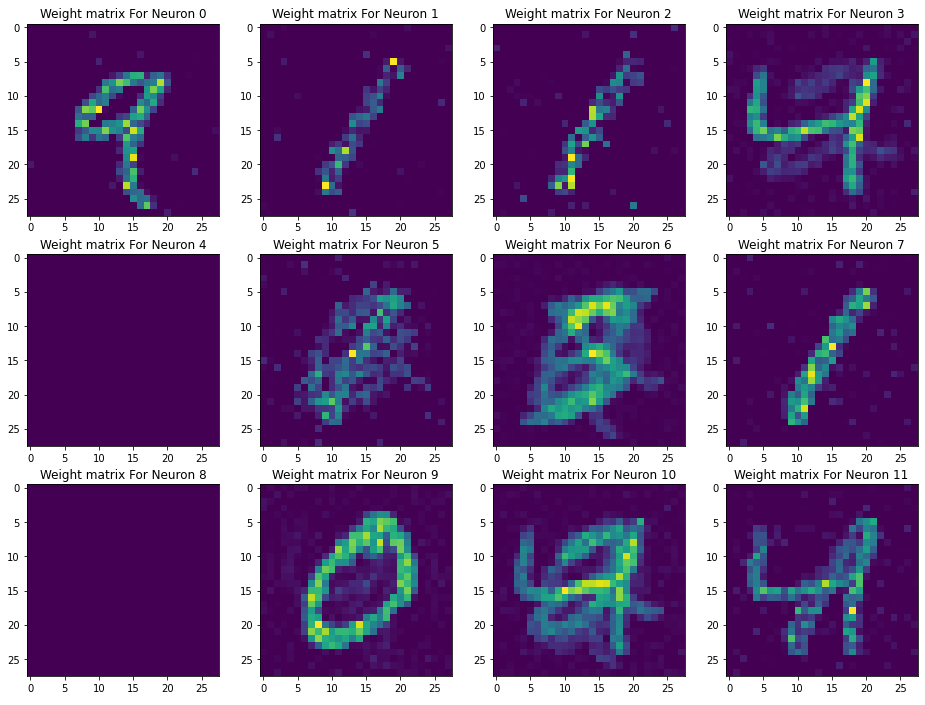

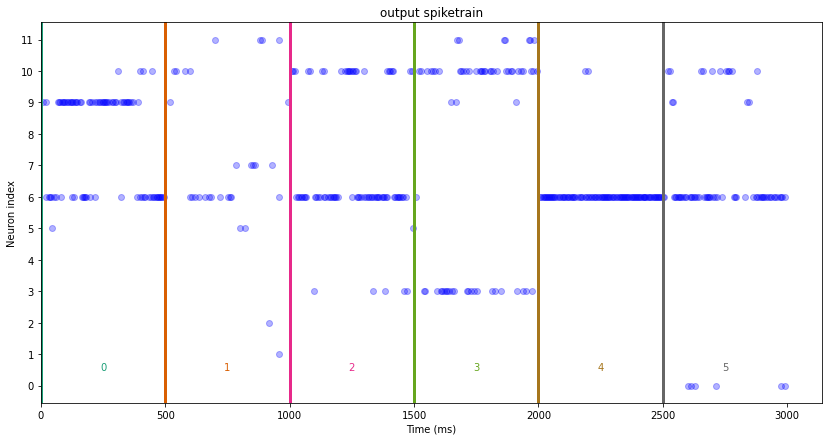

In [10]:
synapse_prob = 1.

input_layer, output_layer = create_network(input_shape, 12)

static_weights = sim.random.RandomDistribution('normal', [0., 0.3])
static_synapses = sim.Projection(input_layer, output_layer,
                                 sim.FixedProbabilityConnector(synapse_prob),
                                 sim.StaticSynapse(weight=static_weights))


plastic_model_exc = sim.STDPMechanism(timing_dependence=sim.SpikePairRule(tau_plus=10.0, tau_minus=10.0,
                                                                          A_plus=1e-5, A_minus=-1e-5),
                                      weight_dependence=sim.MultiplicativeWeightDependence(w_min=0.0, w_max=2.),
                                      weight= 0.000)

plastic_synapses_exc = sim.Projection(input_layer, output_layer,
                                      sim.FixedProbabilityConnector(synapse_prob),
                                      plastic_model_exc)


def lateral_inhib(output_layer, weight):
    n_output_neurons = len(output_layer)
    lateral_inhib = sim.Projection(output_layer, output_layer,
                                   sim.AllToAllConnector(allow_self_connections=False),
                                   sim.StaticSynapse(weight=weight, delay=0.1),
                                   receptor_type='inhibitory'
                                  )
    

lateral_inhib(output_layer, -2.)

simulate_network(stimuli, input_layer)
plot_weights(plastic_synapses_exc)
plot_spiketrain(output_layer, len(stimuli))


To prevent a neuron to become too active, one can also make use of short-term plasticity synapses. Like plastic synapses, they change their weights depending of neuron activity, but the weight changes reset rapidly.

NEST does not allow setting an initial value for V_m
NEST does not allow setting an initial value for isyn_exc
NEST does not allow setting an initial value for isyn_inh
Several STDP models are available for these connections:
stdp_synapse
By default, stdp_synapse is used
/home/jkaiser/.local/lib/python3.6/site-packages/ipykernel_launcher.py:106: MatplotlibDeprecationWarning:Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


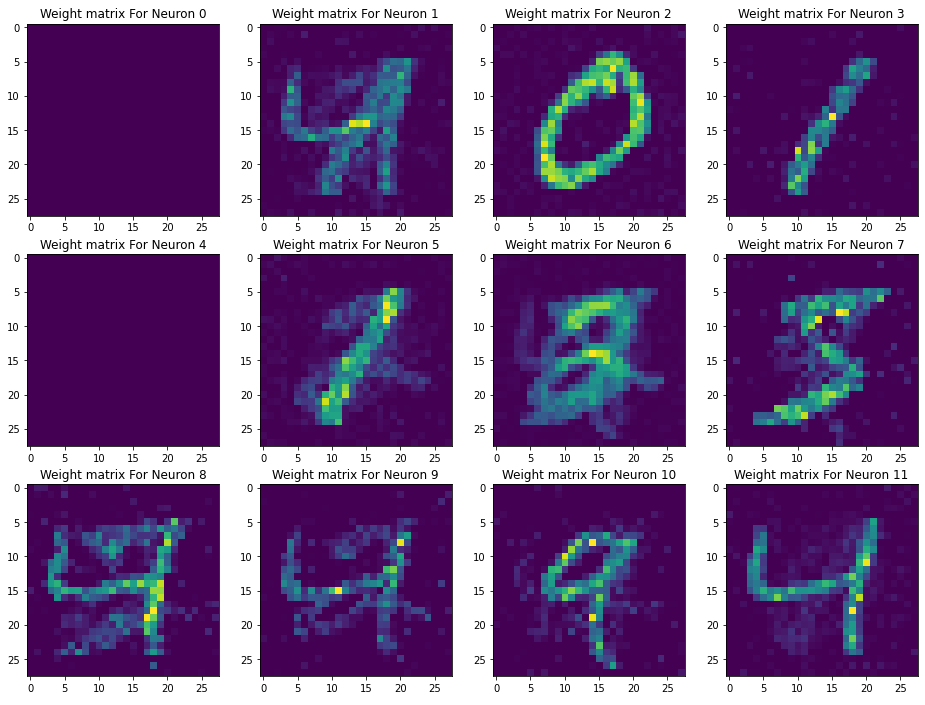

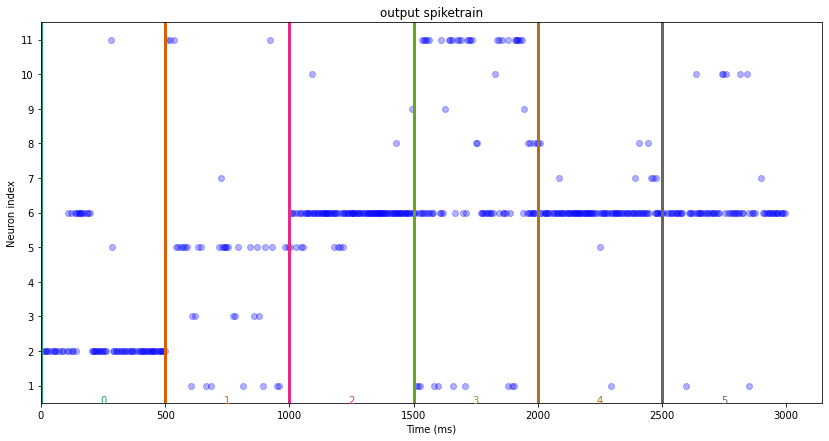

In [11]:
synapse_prob = 1.0

input_layer, output_layer = create_network(input_shape, 12)

static_weights = sim.random.RandomDistribution('normal', [0., 0.3])
static_synapses = sim.Projection(input_layer, output_layer,
                                 sim.FixedProbabilityConnector(synapse_prob),
                                 sim.StaticSynapse(weight=static_weights))



plastic_model_exc = sim.STDPMechanism(timing_dependence=sim.SpikePairRule(tau_plus=10.0, tau_minus=10.0,
                                                                          A_plus=1e-5, A_minus=-1e-5),
                                      weight_dependence=sim.MultiplicativeWeightDependence(w_min=0.0, w_max=2.),
                                      weight= 0.000)

plastic_synapses_exc = sim.Projection(input_layer, output_layer,
                                      sim.FixedProbabilityConnector(synapse_prob),
                                      plastic_model_exc)





def add_short_term_inhib():
    short_term_model = sim.TsodyksMarkramSynapse(weight=-0.005, delay=0.1, U=0.5,
                                                 tau_rec=10.0, tau_facil=500.0)
    sim.Projection(input_layer, output_layer,
                  sim.AllToAllConnector(),
                  short_term_model,
                  receptor_type='inhibitory')
    

def lateral_inhib(output_layer, weight):
    n_output_neurons = len(output_layer)
    lateral_inhib = sim.Projection(output_layer, output_layer,
                                   sim.AllToAllConnector(allow_self_connections=False),
                                   sim.StaticSynapse(weight=weight, delay=0.1),
                                   receptor_type='inhibitory'
                                  )
    

lateral_inhib(output_layer, -2.0)
add_short_term_inhib()

simulate_network(stimuli, input_layer)
plot_weights(plastic_synapses_exc)
plot_spiketrain(output_layer, len(stimuli))
